# Синтез изображений. Часть 2. Генеративно-Состязательная Сеть (GAN)

## Переключение версии TensorFlow

In [1]:
%tensorflow_version 2.x

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

In [3]:
def plot_face(samples):
    fig = plt.figure(figsize=(10, 10))
    num = samples.shape[0]
    for j in range(num):
        ax = fig.add_subplot(8, 8, j+1)
        img = (samples[j, ...])
        img[img > 1] = 1
        img[img < -1] = -1
        img = ((img + 1) * 127).astype('int')
        ax.imshow(img)
        plt.xticks([]), plt.yticks([])
    plt.show()

## Загрузка и подготовка не MNIST датасета



In [4]:
train_ds, ds_info = tfds.load(
    'lfw', 
    as_supervised=True,
    with_info=True,
    #split=['train[:90%]', 'train[90%:]'],
)

In [5]:
train_ds = train_ds['train']

## Визуализация не MNIST датасета



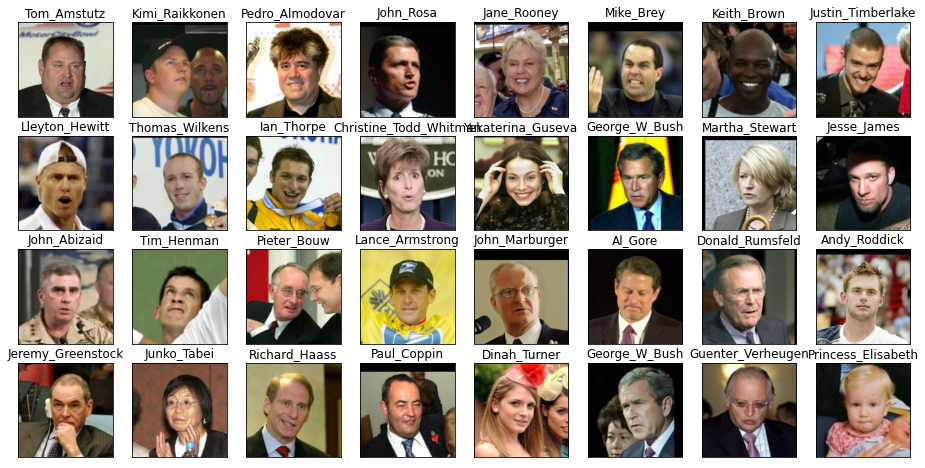

In [6]:
fig = plt.figure(figsize=(16, 8))

for j, (labels, images) in enumerate(iter(train_ds.take(32))): 
    numpy_images = images.numpy()
    #numpy_labels = labels.numpy()
    ax = fig.add_subplot(4, 8, j+1)
    ax.imshow(numpy_images)
    plt.xticks([]), plt.yticks([])
    plt.title(labels.numpy().decode("utf-8"))
plt.show()

## Подготовка пайплайна данных и оптимизатора

In [7]:
numpy_images.shape

(250, 250, 3)

In [8]:
INPUT_DIM = 100
NUM_EPOCHS = 8
HALF_BATCH_SIZE = 16
BATCH_SIZE = HALF_BATCH_SIZE * 2
LEARNING_RATE = 0.0002


def prepare_img(label, img):
    img = tf.cast(img, tf.float32)/127. - 1.
    return tf.image.resize(img, (240, 240))

#train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.map(prepare_img)
#train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(HALF_BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.repeat(NUM_EPOCHS)

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
sigmoid_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

## Создание Генератора и Дискриминатора

In [9]:
generator = tf.keras.Sequential([
    tf.keras.Input(shape=[INPUT_DIM]),

    tf.keras.layers.Dense(128*30*30, activation='relu'),
    tf.keras.layers.Reshape((30, 30, 128)),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2DTranspose(32, (4, 4), strides=(2, 2), padding="same"),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.BatchNormalization(momentum=0.4),

    tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(1, 1), padding="same"),
    tf.keras.layers.LeakyReLU(alpha=0.2),

    tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same"),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.BatchNormalization(momentum=0.4),

    tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(1, 1), padding="same"),
    tf.keras.layers.LeakyReLU(alpha=0.2),

    tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same"),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.BatchNormalization(momentum=0.4),

    tf.keras.layers.Conv2D(3, (3, 3), padding='same', activation='tanh'),
],
    name="generator")

generator.build()
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 115200)            11635200  
_________________________________________________________________
reshape (Reshape)            (None, 30, 30, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 60, 60, 32)        65568     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 60, 60, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 60, 60, 32)        128       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 60, 60, 64)        18

In [10]:


discriminator = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(240, 240, 3)),
        tf.keras.layers.Conv2D(32, (3, 3), padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.BatchNormalization(momentum=0.4),

        tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.BatchNormalization(momentum=0.4),

        tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.BatchNormalization(momentum=0.4),
       
        tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.BatchNormalization(momentum=0.4),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1),
    ],
    name="discriminator",
)

discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 240, 240, 32)      896       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 240, 240, 32)      0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 240, 240, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 120, 120, 64)      18496     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 120, 120, 64)      0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 120, 120, 64)      256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 60, 64)      

## Обучение GAN

[Step  0] D Loss: 0.6942; G Loss: 0.5500


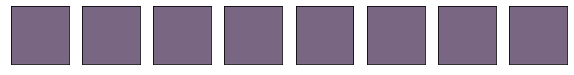

[Step 500] D Loss: 0.9612; G Loss: 5.7732


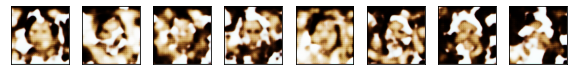

[Step 1000] D Loss: 0.0783; G Loss: 11.9558


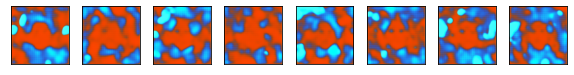

[Step 1500] D Loss: 0.7579; G Loss: 3.9019


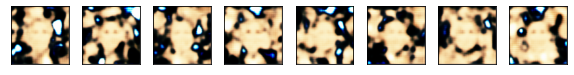

[Step 2000] D Loss: 0.3257; G Loss: 2.4275


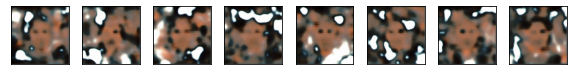

[Step 2500] D Loss: 0.5965; G Loss: 1.4010


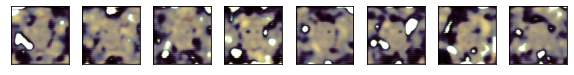

[Step 3000] D Loss: 0.0568; G Loss: 5.6490


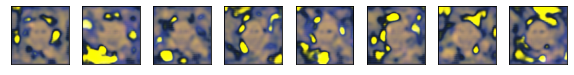

[Step 3500] D Loss: 0.0165; G Loss: 5.9216


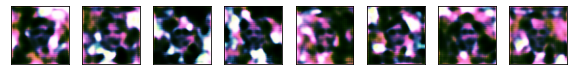

[Step 4000] D Loss: 0.0287; G Loss: 4.3793


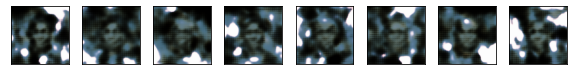

[Step 4500] D Loss: 0.3608; G Loss: 1.4460


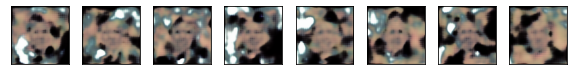

[Step 5000] D Loss: 0.2868; G Loss: 1.5610


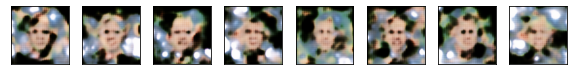

[Step 5500] D Loss: 0.5468; G Loss: 1.4457


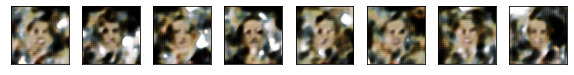

[Step 6000] D Loss: 0.7160; G Loss: 6.1260


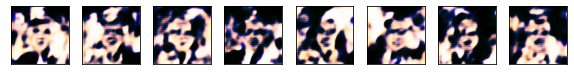

[Step 6500] D Loss: 0.4069; G Loss: 4.3900


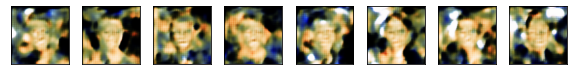

[Step 7000] D Loss: 0.3103; G Loss: 1.5802


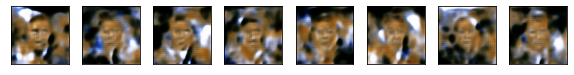

[Step 7500] D Loss: 0.1291; G Loss: 2.7271


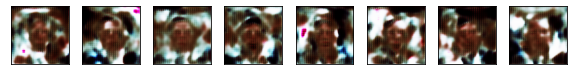

[Step 8000] D Loss: 0.2212; G Loss: 4.0409


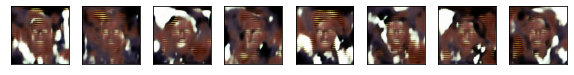

In [11]:
for step, true_images in enumerate(train_ds):
    
    # Train Discriminator
    
    noise = np.random.normal(0, 1, (HALF_BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    syntetic_images = generator.predict(noise)
    x_combined = np.concatenate((
        true_images, 
        syntetic_images))
    y_combined = np.concatenate((
        np.ones((HALF_BATCH_SIZE, 1), np.float32), 
        np.zeros((HALF_BATCH_SIZE, 1), np.float32)))
    
    with tf.GradientTape() as tape:
        logits = discriminator(x_combined)
        d_loss_value = sigmoid_cross_entropy(y_combined, logits)
    grads = tape.gradient(d_loss_value, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))
    
    # Train Generator
    
    noise = np.random.normal(0, 1, (BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    y_mislabled = np.ones((BATCH_SIZE, 1), np.float32)
    
    with tf.GradientTape() as tape:
        logits = discriminator(generator(noise, training=True))
        g_loss_value = sigmoid_cross_entropy(y_mislabled, logits)
    grads = tape.gradient(g_loss_value, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    
    # Check intermediate results
    
    if step % 500 == 0:
        print('[Step %2d] D Loss: %.4f; G Loss: %.4f' % (
            step, d_loss_value.numpy(), g_loss_value.numpy()))
        noise = np.random.normal(0, 1, (8, INPUT_DIM)).astype(np.float32)
        syntetic_images = generator.predict(noise)
        plot_face(syntetic_images)


## Тестирование генератора

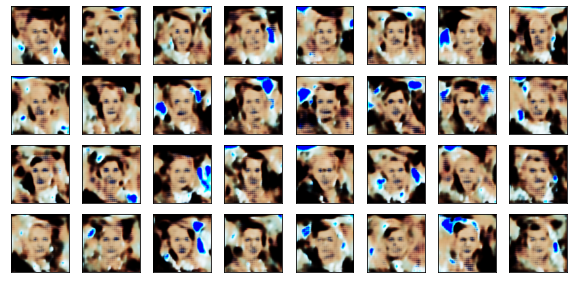

In [12]:
noise = np.random.normal(0, 1, (32, INPUT_DIM)).astype(np.float32)
syntetic_images = generator.predict(noise)
img = plot_face(syntetic_images)

## Интерполяция в латентном пространстве

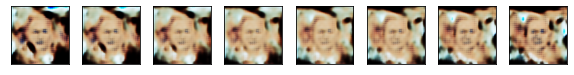

In [13]:
noise_1 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise_2 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise = np.linspace(noise_1, noise_2, 8)
syntetic_images = generator.predict(noise)
plot_face(syntetic_images)